# Analyze Blast Results : Gulf of California Data 18S

1. Look at sequence similarity between USEARCH and BANZAI contigs


In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

#For illustrator import:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#Functions

#Raw Read Numbers
def make_rawread(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df.drop('taxonomy', axis=1, inplace=True)
    df.drop('repseq', axis=1, inplace=True)
    df.set_index('OTU', inplace=True)
    return df
    
#metadata handling and sample order
def make_metadata(infile):
    df = pd.read_csv(infile)
    #make all column names with underscore
    columns_l = list(df)
    columns_l = [c.replace('-', '_') for c in columns_l]
    df.columns = columns_l
    #extract site name
    df['site'] = df['sample_name'].str.extract('([a-zA-Z0-9]+)')
    df_full = df[:]
    #add in some missing location data
    df_full.loc[df_full['site']=='UC5', 'dec_lat'] = 32
    df_full.loc[df_full['site']=='UC5', 'dec_long'] = '.118.17'
    df_full['dec_long'] = df_full['dec_long'].str.replace('^\.','-')
    df_full.set_index('sample_name', inplace=True)
    df= df[['Description', 'Treatment', 'sample_name']]
    df['comb'] = df['Description']+'_'+df['Treatment']+'_'+df['sample_name']
    df['site_Order']=df['sample_name'].str.replace('GOC2a', '16').str.replace('GOC2b', '17').str.replace('NTC', '0')
    df['site_Order']=df['site_Order'].str.extract('(\d+)')
    df.set_index('sample_name', inplace=True)
    df['site_Order']= df['site_Order'].astype(int)
    df.sort_values('site_Order', ascending=True, inplace=True)
    return df_full, df

#DESEQ Numbers
def make_deseq(infile):
    df = pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    return df

#Rarefied Read Numbers (From R script); make compositional
def make_rarereads_comp(infile):
    df= pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df.T
    df['Total']=df.sum(axis=1)
    tot_reads = df['Total'].tolist()
    tot_reads = set(tot_reads)
    print('Rarefied read count:', tot_reads)
    tot_reads = df['Total'].tolist()[0]
    df = df/tot_reads *100
    df.drop('Total', axis=1, inplace=True)
    df=df.T
    return df

def make_rarereads(infile):
    df= pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    return df

#Taxa table
def make_taxa(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df = df[['taxonomy', 'OTU']]
    df.set_index('OTU', inplace=True)
    df['Kingdom']=df['taxonomy'].str.split("\'").str[1]
    df['Phylum']=df['taxonomy'].str.split("\'").str[3]
    df['Class']=df['taxonomy'].str.split("\'").str[5]
    df['Order']=df['taxonomy'].str.split("\'").str[7]
    df['Family']=df['taxonomy'].str.split("\'").str[9]
    df['Genus']=df['taxonomy'].str.split("\'").str[11]
    df['Species']=df['taxonomy'].str.split("\'").str[13]
    df=df.drop('taxonomy', axis=1)
    return df

#Filtered Taxa table
def make_Ftaxa(infile):
    df = pd.read_csv(infile, sep=',')
    df.rename(columns={'OTU_ID':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df[df.columns[-7:]]
    return df

#extract sequences
def make_seq(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df[['repseq']]
    return df

# Import Banzai Results

In [3]:
#18S_M6
print('18S')
#OTU_table_taxa_all.txt location
file_loc1 = '/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/18S/Analysis_20190924_1129/all_lib/Post_Blast_20190930_1343/OTU_table_taxa_all.txt'
#metadata
meta_file = '/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/18S/Analysis_20190924_1129/GOC_18S_Metadata.csv'
#DESEQ data
#file2 = '/Users/kpitz/Projects/Gulf_of_California/Deseq/18S_GOC_DEseq_122117.csv'
#rarefied data
#file3 = '/Users/kpitz/Projects/MBON/Rarefied_Data_unmerged/GOC_18S_OTU_Table_071018_M6.csv'
#Filtered OTU table
file4 = '/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/18S/Analysis_20190924_1129/all_lib/Filtered_OTU_taxa_table_all.csv'


raw_18S = make_rawread(file_loc1)
meta_18S, samp_lim_18S = make_metadata(meta_file)
#deseq_18S = make_deseq(file2)
#rare_18S = make_rarereads(file3)
#rare_comp_18S = make_rarereads_comp(file3)
taxa_18S = make_taxa(file_loc1)
Ftaxa_18S = make_Ftaxa(file4)
seq_18S = make_seq(file_loc1)

#Directory for saving Figures
plot_dir = '/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/'
plot_name = 'GOC_18SCOI_'
Plot_str = plot_dir + plot_name
print(Plot_str)

#Use to change the name of the databases
name1 = 'GOC_18SCOI_'

18S
/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/GOC_18SCOI_


# Import Filtered Banzai Results

Created in GOC_18S_Filter_Data.ipynb

- /Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_18S_seq_table_100119.csv
- /Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_18S_otu_table_100119.csv
- /Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_18S_taxa_table_100119.csv
- /Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_18S_Filtered_OTUs_100119.fasta

In [4]:
files = ['/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_18S_seq_table_100119.csv',
         '/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_18S_otu_table_100119.csv',
         '/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_18S_taxa_table_100119.csv']
#dfs = [seq_18S_filt, raw_18S_filt, Ftaxa_18S_filt]
df = pd.read_csv(files[0])
df.set_index('Unnamed: 0', inplace=True)
df.index.rename('OTU', inplace=True)
seq_18S_filt = df.copy()

df = pd.read_csv(files[1])
df.set_index('Unnamed: 0', inplace=True)
df.index.rename('OTU', inplace=True)
raw_18S_filt = df.copy()

df = pd.read_csv(files[2])
df.set_index('Unnamed: 0', inplace=True)
df.index.rename('OTU', inplace=True)
Ftaxa_18S_filt = df.copy()

df.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU,,,,,,,
OTU_1,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Calanidae,Calanus,s_
OTU_10,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Metridinidae,Metridia,Metridia lucens
OTU_100,Eukaryota,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,g_,s_
OTU_100012,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Metridinidae,Metridia,Metridia lucens
OTU_100017,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Calanidae,Calanus,s_


# Import USEARCH Data

In [5]:
#rarefied datasets
Geller_18S = pd.read_csv('/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/18S_Geller_MGmodified_9Jan19.txt', sep='	')
Geller_18S
#original 18S before mistake fixed (OTU_67 included and taxonomy wrong- sequences also wrong)
#Geller_18So = pd.read_csv('/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/Incorrect_18S/18S_Geller.txt', sep='	')
#Geller_18So
Geller_COI = pd.read_csv('/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/COI_Geller.txt', sep='	')
Geller_COI

#non-rarefied datasets
file= '/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/Not_rarefied/MBARI_18S_otu_table_10097_txt.txt'
Geller_18S_nr = pd.read_csv(file, sep='	')
Geller_18S_nr
file= '/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/Not_rarefied/MBARI_COI_otu_table_10095_txt.txt'
Geller_COI_nr = pd.read_csv(file, sep='	')
Geller_COI_nr.head()




,#OTU ID,CP23_1,CP23_2,CP23,GOC2a,GOC2b,UC10,UC12,UC13,UC14,...,UC1,UC2,UC3_1,UC3_2,UC3,UC4,UC5,UC6,UC7,UC9
0,OTU_659,56525,9789,50014,0,0,0,4,9,90,...,0,0,2,1,0,9,0,0,0,9
1,OTU_187,2464,93987,3134,0,0,0,19,0,1,...,0,10,1,0,0,0,0,0,0,0
2,OTU_183,477,236,590,2,40,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OTU_388,23844,4576,23573,0,0,0,1,3,47,...,3,10,2248,186,6090,5,0,0,0,3
4,OTU_1058,1050,1499,1015,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Import Blast Results

# Parse Blastn XML files

In [6]:
from Bio.Blast import NCBIXML

In [7]:
#Banzai data as a query, USEARCH data as the database
#filename = '/Users/kpitz/Projects/Gulf_of_California/Geller_MB_blastn/Gellerquery_MBdb_COI_blastn_092419.xml'
filename = '/Users/kpitz/Projects/Gulf_of_California/Geller_MB_blastn/MBquery_Gellerdb_18S_blastn_100119.xml'

result_handle =open(filename)
blast_records= NCBIXML.parse(result_handle)
#Dictionary to store hits
hit_dict ={}
for blast_record in blast_records:
    #query = blast_record.query.split('|')[1]
    query = blast_record.query
    #print(query)
    hit_ID=0
    for alignment in blast_record.alignments:
        hit_ID+=1       #hit ID counter
        if hit_ID >2:
            continue
        key = (query, hit_ID)
        hsp = alignment.hsps[0] #only look at top hsp
        #set limits on evalue and bitscore and % Identity
        per_iden = hsp.identities/float(hsp.align_length)
        per_iden = (per_iden *100)
        per_iden = round(per_iden, 2)
        evalue = hsp.expect
        bitscore = int(hsp.bits)
        #alignment length
        align_len = hsp.align_length
        
        value = (evalue, bitscore, per_iden, alignment.hit_def, align_len)
        hit_dict[key]=value

print ('Done parsing Blast xml File!')
#Save blast result stats to file
Blast_Results = pd.DataFrame(hit_dict)
Blast_Results=Blast_Results.T
Blast_Results.columns = ['eval','bitscore', '%ID', 'hit_def', 'align_len']

MBq = Blast_Results.copy()
MBq


Done parsing Blast xml File!


eval bitscore    %ID  \
DUP_100012;size=2 1  3.15295e-175      604  96.95   
                  2  2.47211e-166      575  95.34   
DUP_100017;size=2 1             0      638  98.35   
                  2  8.96882e-166      573  95.08   
DUP_100020;size=2 1             0      643  98.63   
                  2  1.47545e-173      599  96.43   
DUP_100021;size=2 1  4.08516e-179      617  97.25   
                  2  8.84281e-176      606  96.71   
DUP_100035;size=2 1  4.08516e-179      617  97.25   
                  2  1.16019e-164      569  94.81   
DUP_100036;size=2 1  8.84281e-176      606  96.71   
                  2  1.14389e-174      603  96.45   
DUP_100037;size=2 1             0      623  97.53   
                  2  5.35979e-168      580  95.36   
DUP_100038;size=2 1  3.17128e-175      604   96.7   
                  2  6.96243e-162      560  94.51   
DUP_100041;size=2 1             0      640  98.35   
                  2  2.47609e-171      592   95.9   
DUP_100042;size=2 1             0      634  98.08   
                  2  1.14719e-174      603  96.44   
DUP_100044;size=2 1             0      645  98.63   
                  2  1.15201e-169      586  95.63   
DUP_100045;size=2 1             0      623  97.53   
                  2  2.45863e-176      608  96.72   
DUP_100049;size=2 1             0      645  98.63   
                  2  6.88445e-172      593  96.15   
DUP_100051;size=2 1  1.14389e-174      603  96.45   
                  2  1.91413e-172      595  96.16   
DUP_100052;size=2 1  1.90064e-177      612  96.98   
                  2  8.84281e-176      606   96.7   
...                           ...      ...    ...   
DUP_99974;size=2  1             0      645  98.63   
                  2  2.47609e-171      592  95.91   
DUP_99975;size=2  1             0      640  98.35   
                  2  1.49022e-168      582   95.6   
DUP_99976;size=2  1  2.29056e-171      592  98.22   
                  2  1.91401e-117      412  88.37   
DUP_99977;size=2  1             0      662  97.67   
                  2             0      649  97.14   
DUP_99984;size=2  1  4.08516e-179      617  97.25   
                  2  8.84281e-176      606  96.71   
DUP_99986;size=2  1  1.88968e-177      612  97.23   
                  2  1.48163e-168      582  95.62   
DUP_99989;size=2  1  1.90064e-177      612  96.99   
                  2  2.49367e-166      575   95.1   
DUP_99990;size=2  1   1.1373e-174      603  96.69   
                  2  1.48163e-168      582   95.6   
DUP_99992;size=2  1  4.08516e-179      617  97.25   
                  2  8.84281e-176      606  96.71   
DUP_99994;size=2  1             0      623  97.53   
                  2  2.45863e-176      608  96.72   
DUP_99995;size=2  1  6.83591e-177      610  96.97   
                  2  1.47972e-173      599  96.44   
DUP_99997;size=2  1  4.08516e-179      617  97.25   
                  2  8.84281e-176      606  96.71   
DUP_99998;size=2  1             0      640  98.35   
                  2  4.11416e-174      601  96.43   
DUP_99999;size=2  1             0      638  98.35   
                  2  9.00647e-161      556  94.25   
DUP_9;size=83898  1             0      651  98.64   
                  2             0      636  97.83   

                                                               hit_def  \
DUP_100012;size=2 1  Geller_18S|OTU_72|34487| Arthropoda_ Maxillopo...   
                  2     Geller_18S|OTU_106|852|NaN_NaN_NaN_NaN_NaN_NaN   
DUP_100017;size=2 1  Geller_18S|OTU_340|693| Arthropoda_ Maxillopod...   
                  2  Geller_18S|OTU_134|11606| Arthropoda_ Maxillop...   
DUP_100020;size=2 1  Geller_18S|OTU_6|258357| Arthropoda_ Maxillopo...   
                  2  Geller_18S|OTU_11|28855| Arthropoda_ Maxillopo...   
DUP_100021;size=2 1   Geller_18S|OTU_28|229012|NaN_NaN_NaN_NaN_NaN_NaN   
                  2  Geller_18S|OTU_75|311940| Arthropoda_ Maxillop...   
DUP_100035;size=2 1  Geller_18S|OTU_6|258357| Arthropoda_ Maxillopo...   
  

In [8]:
df= MBq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['OTU'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['hit_def'].str.split('|').str[1]
df.set_index('MB_OTU', inplace=True)
df=df.join(seq_18S)
df['seqlen'] = df['repseq'].str.len()
print('Total OTUs with Hits:',len(df.index))
#tot_otus = len(raw_18S.index) #total OTUs blasted
print('Total OTUs Blasted:',len(raw_18S.index))
print('Total Filtered OTUs Blasted:',len(raw_18S_filt.index))
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#remove OTUs that were filtered out
cols = list(raw_18S_filt)
df= df.join(raw_18S_filt)
df['tot'] = df[cols].sum(axis=1)
df.drop(cols, inplace=True, axis=1)
df=df.sort_values('tot')
df=df.loc[df['tot']!=0]
print('Total OTUs with Hits minus Filtered OTUs:',len(df.index))
tot_otus = len(raw_18S_filt.index) #total non-filtered OTUs blasted

#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']>=95]
df=df.loc[df['%ID']>=97]
print('Total OTUs with Good Hits:',len(df.index))
good_otus = len(df.index)
print('Of Filtered OTUs::::')
print('Percent Hits with >95% query coverage, >97% sequence identity:', good_otus/tot_otus *100)


df.head()

Total OTUs with Hits: 51900
Total OTUs Blasted: 51910
Total Filtered OTUs Blasted: 44837
Total OTUs with Hits minus Filtered OTUs: 44831
Total OTUs with Good Hits: 33542
Of Filtered OTUs::::
Percent Hits with >95% query coverage, >97% sequence identity: 74.80875170060442


,OTU,Hit_number,eval,bitscore,%ID,hit_def,align_len,USEARCH_OTU,repseq,seqlen,Per_query,tot
MB_OTU,,,,,,,,,,,,
OTU_267762,DUP_267762;size=2,1,0,651,98.9,Geller_18S|OTU_28|229012|NaN_NaN_NaN_NaN_NaN_NaN,364,OTU_28,tgtggtagccgttctaaaggctccctctccggaatcgaaccctgat...,364,100,2.0
OTU_240679,DUP_240679;size=2,1,0,628,97.55,Geller_18S|OTU_2|196041| Cnidaria_ Hydrozoa_ S...,367,OTU_2,tgtggtagccgtttctcaggctccctctccggaatcgaaccctaat...,367,100,2.0
OTU_240928,DUP_240928;size=2,1,0,638,98.09,Geller_18S|OTU_2|196041| Cnidaria_ Hydrozoa_ S...,366,OTU_2,tgtggtagccgtttctcaggctccctctccggaatcgaaccctaat...,367,99.7275,2.0
OTU_240903,DUP_240903;size=2,1,0,634,97.82,Geller_18S|OTU_2|196041| Cnidaria_ Hydrozoa_ S...,367,OTU_2,tgtggtagccgtttctcaggctccctctccggaatcgaaccctaat...,367,100,2.0
OTU_267774,DUP_267774;size=2,1,1.46928e-178,616,97.25,Geller_18S|OTU_336|1639| Ctenophora_ Tentacula...,363,OTU_336,tgtggtagccgttcctcgggctccctctccggaatcgaaccctaat...,364,99.7253,2.0


In [9]:
#investigate Bad hits

df= MBq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['OTU'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['hit_def'].str.split('|').str[1]
df.set_index('MB_OTU', inplace=True)
df=df.join(seq_18S)
df['seqlen'] = df['repseq'].str.len()
print('Total OTUs with Hits:',len(df.index))
#tot_otus = len(raw_18S.index) #total OTUs blasted
print('Total OTUs Blasted:',len(raw_18S.index))
print('Total Filtered OTUs Blasted:',len(raw_18S_filt.index))

#only look at OTUs that passed the filter
cols =list(raw_18S_filt)
df=pd.concat([df, raw_18S_filt], axis=1)
df['Total_Filtered_reads'] = df[cols].sum(axis=1)
df=df.loc[df['Total_Filtered_reads']>0]
print('Total Filtered OTUs with Hits:', len(df.index))

df['Per_query'] = df['align_len']/ df['seqlen'] *100

df1=df.loc[df['Per_query']>=95]
print('Total Filtered OTUs with Per_query >=95 Hits:', len(df1.index))

df1=df1.loc[df1['%ID']>=95]
print('Total Filtered OTUs with %ID >=95 Hits:', len(df1.index))

tot_otus = len(raw_18S_filt.index) #total non-filtered OTUs blasted
print(tot_otus)
good_otus = len(df1.index)
print(good_otus)
print('Of Filtered OTUs::::')
print('Percent Hits with >95% query coverage, >95% sequence identity:', good_otus/tot_otus *100)

print('OTUs that do not have good hits:::')
#now look at otus that don't have good hits:
cols = list(raw_18S_filt)
df = pd.concat([raw_18S_filt, df1], axis=1)
print(len(df.index))
df['Total_Filtered_reads'] = df[cols].sum(axis=1)
print('min reads: ',df['Total_Filtered_reads'].min())
df=df.drop(cols, axis=1)

df=df.loc[df['Per_query'].isna()==True]
df['Bad_Hit']=1
print(len(df.index))
#df1=df1.loc[df1['%ID']<95]
#df=df.sort_values('Per_query')

df=pd.concat([df, Ftaxa_18S_filt.fillna('not assigned')], axis=1)
df=df.loc[df['Bad_Hit']==1]
#print(len(df.index))
levels = list(Ftaxa_18S_filt)
#df=df.groupby(levels).sum()
df=df.groupby(['Phylum','Class']).sum()
df=df.sort_values('Bad_Hit', ascending=False)
df

Total OTUs with Hits: 51900
Total OTUs Blasted: 51910
Total Filtered OTUs Blasted: 44837


/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Total Filtered OTUs with Hits: 44837
Total Filtered OTUs with Per_query >=95 Hits: 44718
Total Filtered OTUs with %ID >=95 Hits: 43572
44837
43572
Of Filtered OTUs::::
Percent Hits with >95% query coverage, >95% sequence identity: 97.1786694025024
OTUs that do not have good hits:::


/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



44837
min reads:  2.0
1265


/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Hit_number  seqlen  Total_Filtered_reads  \
Phylum          Class                                                           
Arthropoda      Hexanauplia                 0.0     0.0                1036.0   
                Malacostraca                0.0     0.0                 718.0   
Cnidaria        Hydrozoa                    0.0     0.0                 275.0   
unknown         Dinophyceae                 0.0     0.0                 174.0   
not assigned    not assigned                0.0     0.0                 126.0   
Chaetognatha    Sagittoidea                 0.0     0.0                  73.0   
Chordata        Appendicularia              0.0     0.0                  62.0   
Mollusca        Gastropoda                  0.0     0.0                  75.0   
Chordata        Thaliacea                   0.0     0.0                  69.0   
p_              c_                          0.0     0.0                  49.0   
unknown         Polycystinea                0.0     0.0                  42.0   
Annelida        Polychaeta                  0.0     0.0                  32.0   
unknown         unknown                     0.0     0.0                  30.0   
Chlorophyta     Palmophyllophyceae          0.0     0.0                  13.0   
Arthropoda      Ostracoda                   0.0     0.0                  12.0   
Bacillariophyta Coscinodiscophyceae         0.0     0.0                  12.0   
Ctenophora      Tentaculata                 0.0     0.0                  11.0   
Echinodermata   Holothuroidea               0.0     0.0                   9.0   
Brachiopoda     c_                          0.0     0.0                   8.0   
Chordata        Actinopteri                 0.0     0.0                   6.0   
Mollusca        Bivalvia                    0.0     0.0                   6.0   
unknown         Oligohymenophorea           0.0     0.0                  11.0   
Haplosporidia   unknown                     0.0     0.0                   4.0   
Chlorophyta     Trebouxiophyceae            0.0     0.0                   6.0   
unknown         Pelagophyceae               0.0     0.0                   4.0   
Xenacoelomorpha Acoela                      0.0     0.0                   2.0   
unknown         Acantharea                  0.0     0.0                   2.0   
                Spirotrichea                0.0     0.0                   2.0   
Bacillariophyta Fragilariophyceae           0.0     0.0                   2.0   
Basidiomycota   Tritirachiomycetes          0.0     0.0                   7.0   
Nemertea        Enopla                      0.0     0.0                   2.0   
Platyhelminthes Trematoda                   0.0     0.0                   2.0   
                Cestoda                     0.0     0.0                   2.0   
Nemertea        Pilidiophora                0.0     0.0                   2.0   
Brachiopoda     Lingulata                   0.0     0.0                   2.0   
Echinodermata   Asteroidea                  0.0     0.0                   2.0   
Apicomplexa     Conoidasida                 0.0     0.0                   2.0   
Cnidaria        Scyphozoa                   0.0     0.0                   4.0   
Chlorophyta     Chlorodendrophyceae         0.0     0.0                   2.0   
Chordata        Aves                        0.0     0.0                   3.0   
Ctenophora      Nuda                        0.0     0.0                   2.0   

                                     Bad_Hit  
Phylum          Class                         
Arthropoda      Hexanauplia            482.0  
                Malacostraca           310.0  
Cnidaria        Hydrozoa                87.0  
unknown         Dinophyceae             73.0  
not assigned    not assigned            62.0  
Chaetognatha    Sagittoidea             36.0  
Chordata        Appendicularia          31.0  
Mollusca        Gastropoda              29.0  
Chordata        Thaliacea               28.0  
p_              c_                  

Total OTUs with Hits: 51900
Total OTUs Blasted: 51910
Total Filtered OTUs Blasted: 44837
Total OTUs with Hits minus Filtered OTUs: 44831
Total OTUs with Hits that don't qualify as good: 44
44
44


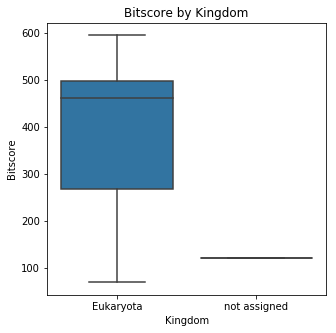

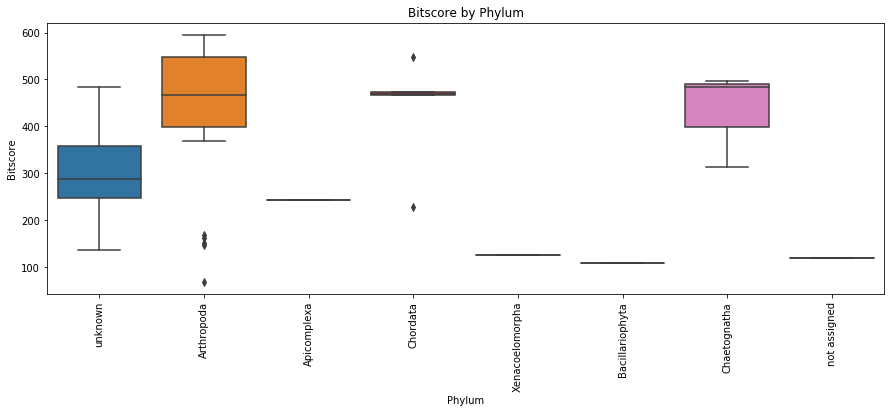

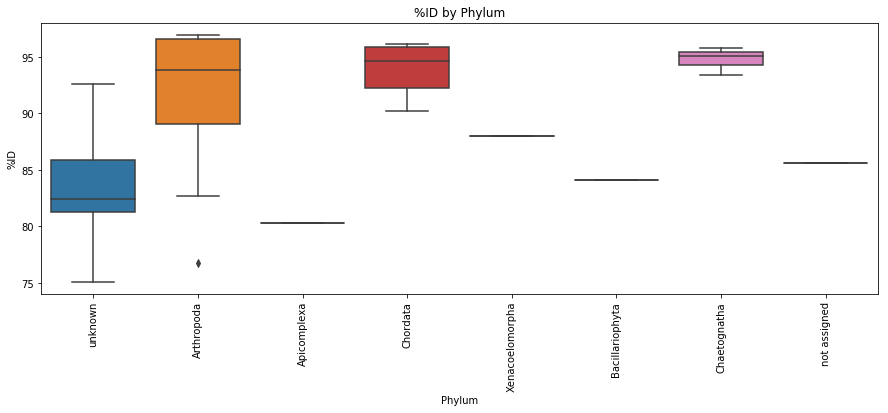

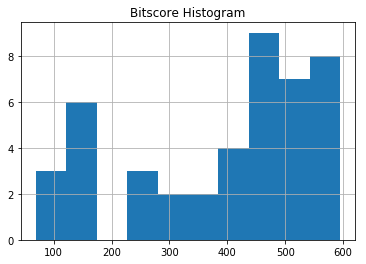

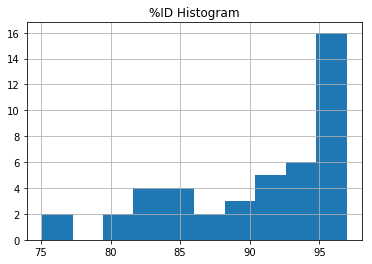

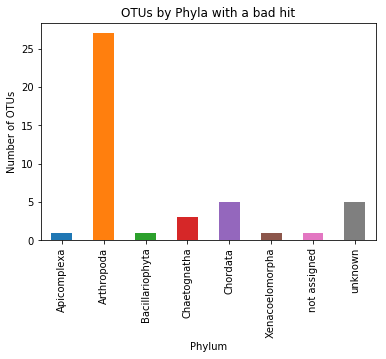

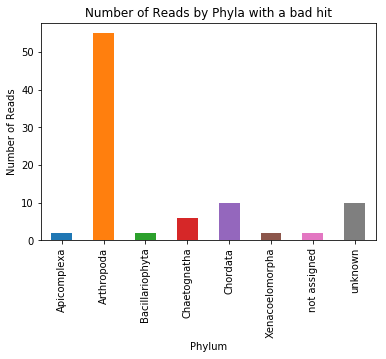

,eval,bitscore,%ID,align_len,Per_query,tot,count
Phylum,,,,,,,
Apicomplexa,7.918070e-67,244,80.30,335,92.797784,2.0,1
Arthropoda,4.876900e-14,11629,2480.74,8083,2235.838634,55.0,27
Bacillariophyta,3.101280e-26,110,84.07,113,30.458221,2.0,1
Chaetognatha,2.053000e-87,1293,284.31,827,227.329231,6.0,3
Chordata,7.719290e-62,2184,469.17,1442,404.178587,10.0,5


In [11]:
# Look at OTUs with bad hits:
df= MBq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['OTU'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['hit_def'].str.split('|').str[1]
df.set_index('MB_OTU', inplace=True)
df=df.join(seq_18S)
df['seqlen'] = df['repseq'].str.len()
print('Total OTUs with Hits:',len(df.index))
#tot_otus = len(raw_18S.index) #total OTUs blasted
print('Total OTUs Blasted:',len(raw_18S.index))
print('Total Filtered OTUs Blasted:',len(raw_18S_filt.index))
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#remove OTUs that were filtered out
cols = list(raw_18S_filt)
df= df.join(raw_18S_filt)
df['tot'] = df[cols].sum(axis=1)
df.drop(cols, inplace=True, axis=1)
df=df.sort_values('tot')
df=df.loc[df['tot']!=0]
print('Total OTUs with Hits minus Filtered OTUs:',len(df.index))
tot_otus = len(raw_18S_filt.index) #total non-filtered OTUs blasted

#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']<95]
df=df.loc[df['%ID']<97]
print('Total OTUs with Hits that don\'t qualify as good:',len(df.index))
df= df[['eval', 'bitscore', '%ID', 'align_len', 'Per_query', 'tot', 'USEARCH_OTU']]
df=pd.concat([df, Ftaxa_18S_filt], axis=1, join='inner')
df =df.fillna('not assigned')
print(len(df.index))

df=df.loc[df['bitscore']>0]
print(len(df.index))

import seaborn as sns
plt.figure(figsize=[5,5])
ax= sns.boxplot(data=df, y='bitscore', x='Kingdom')
plt.title('Bitscore by Kingdom')
plt.ylabel('Bitscore')
plt.show()

plt.figure(figsize=[15,5])
ax= sns.boxplot(data=df, y='bitscore', x='Phylum')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#g.set_xticklabels(rotation=90, labels=df['Class'].tolist())
plt.title('Bitscore by Phylum')
plt.ylabel('Bitscore')
plt.show()

plt.figure(figsize=[15,5])
ax= sns.boxplot(data=df, y='%ID', x='Phylum')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#g.set_xticklabels(rotation=90, labels=df['Class'].tolist())
plt.title('%ID by Phylum')
plt.ylabel('%ID')
plt.show()

df['bitscore'].hist()
plt.title('Bitscore Histogram')
plt.show()
df['%ID'].hist()
plt.title('%ID Histogram')
plt.show()


df['count']=1
df=df.groupby('Phylum').sum()
df['count'].plot(kind='bar')
plt.title('OTUs by Phyla with a bad hit')
plt.ylabel('Number of OTUs')
plt.show()

df['tot'].plot(kind='bar')
plt.title('Number of Reads by Phyla with a bad hit')
plt.ylabel('Number of Reads')
plt.show()


df.head()

In [13]:
#look at OTUs that don't have bad + no hits all together
levels = list(Ftaxa_18S_filt)
df= MBq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['OTU'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['hit_def'].str.split('|').str[1]
df.set_index('MB_OTU', inplace=True)
df=df.join(seq_18S)
df['seqlen'] = df['repseq'].str.len()
print('Total OTUs with Hits:',len(df.index))
#tot_otus = len(raw_18S.index) #total OTUs blasted
print('Total OTUs Blasted:',len(raw_18S.index))
print('Total Filtered OTUs Blasted:',len(raw_18S_filt.index))
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#remove OTUs that were filtered out
cols = list(raw_18S_filt)
df= df.join(raw_18S_filt)
df['tot'] = df[cols].sum(axis=1)
df.drop(cols, inplace=True, axis=1)
df=df.sort_values('tot')
df=df.loc[df['tot']!=0]
print('Total OTUs with Hits minus Filtered OTUs:',len(df.index))
tot_otus = len(raw_18S_filt.index) #total non-filtered OTUs blasted

#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']>=95]
df=df.loc[df['%ID']>=97]
df['good']=1
df1 = Ftaxa_18S_filt.copy()
#df1 = taxa_18S.copy()
df1.fillna('not_assigned', inplace=True)
print(len(Ftaxa_18S_filt.index))

df=pd.concat([df[['good']], df1], axis=1)
df=df.sort_index()
print(len(df.index))
#df=df.loc[df['Kingdom'].isna()==True]
df=df.loc[df['good']!=1]
df.drop('good', axis=1, inplace=True)
cols = list(raw_18S_filt)
df = pd.concat([df, raw_18S_filt], axis=1, join='inner')
df['tot']=df[cols].sum(axis=1)
df.drop(cols, axis=1, inplace=True)
df['count']=1
#df= df.groupby(levels).sum()
df= df.groupby(levels[:3]).sum()
df=df.sort_values('tot', ascending=False)
df=df.sort_values('count', ascending=False)
df


Total OTUs with Hits: 51900
Total OTUs Blasted: 51910
Total Filtered OTUs Blasted: 44837
Total OTUs with Hits minus Filtered OTUs: 44831
44837
44837


/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



tot  count
Kingdom      Phylum          Class                            
Eukaryota    Arthropoda      Hexanauplia          14024   6598
                             Malacostraca          4594   2145
not assigned not assigned    not assigned          1282    626
Eukaryota    Cnidaria        Hydrozoa              1235    439
             Chordata        Appendicularia         666    325
                             Thaliacea              562    258
             p_              c_                     526    250
             Chaetognatha    Sagittoidea            337    158
             unknown         Dinophyceae            346    156
             Mollusca        Gastropoda             189     71
             Ctenophora      Tentaculata            123     50
             Annelida        Polychaeta              87     40
             unknown         Polycystinea            56     24
             Chordata        Actinopteri             38     19
             Ctenophora      Nuda                    39     16
             unknown         unknown                 38     14
             Arthropoda      c_                      28     14
                             Branchiopoda            29      9
             Bacillariophyta Coscinodiscophyceae     20      8
             Ascomycota      Dothideomycetes         16      8
             Chlorophyta     Palmophyllophyceae      13      6
             Arthropoda      Ostracoda               12      6
             Cnidaria        Anthozoa                10      5
             unknown         Acantharea              10      5
             Echinodermata   Holothuroidea            9      4
             Brachiopoda     c_                       8      4
             unknown         Oligohymenophorea       11      3
             Mollusca        Bivalvia                 6      3
             Echinodermata   Asteroidea               6      3
             Chlorophyta     Trebouxiophyceae         6      2
             Ascomycota      Saccharomycetes          5      2
             Bryozoa         Gymnolaemata             4      2
             unknown         Pelagophyceae            4      2
             Haplosporidia   unknown                  4      2
             Nemertea        Pilidiophora             2      1
             Bacillariophyta Fragilariophyceae        2      1
             Brachiopoda     Lingulata                2      1
             Chlorophyta     Chlorodendrophyceae      2      1
             Apicomplexa     Conoidasida              2      1
             Echinodermata   Ophiuroidea              2      1
             Gastrotricha    unknown                  2      1
             Nemertea        Enopla                   2      1
             unknown         Spirotrichea             2      1
             Platyhelminthes Cestoda                  2      1
             Arthropoda      Chilopoda                2      1
             Xenacoelomorpha Acoela                   2      1
             Basidiomycota   Tritirachiomycetes       7      1
             Platyhelminthes Trematoda                2      1
             Chordata        Aves                     3      1
                             Ascidiacea               3      1
             Cnidaria        Scyphozoa                4      1
                             unknown                  2      1

[('Filt', 'Kingdom'), ('Filt', 'Phylum'), ('Filt', 'Class'), ('Filt', 'Order'), ('Filt', 'Family'), ('Filt', 'Genus'), ('Filt', 'Species'), ('norm', 'Kingdom'), ('norm', 'Phylum'), ('norm', 'Class'), ('norm', 'Order'), ('norm', 'Family'), ('norm', 'Genus'), ('norm', 'Species'), 'repseq']
['tgtggtagctatttctcaggctccctctcctgaatcaaaccctaattctccgtcacccgtcatggccatggtaatccaatgcattaccgtcggaagctgataggtcagaaacttaaatgggctatcgcgggtcgaggccgtgcaattcgctatgctatcatgaatcatcaaagagctaggcggagcctagattgattctgttgctgatataagccatctttcttcggagtcacatgttcagtcacgtattagctctagcatttccagagttatccatttagtcaacgtatccaagtaaattatagctgttttaatgagccatttgcagtttcagtgtacaaaacttaatactcagacatgcat']


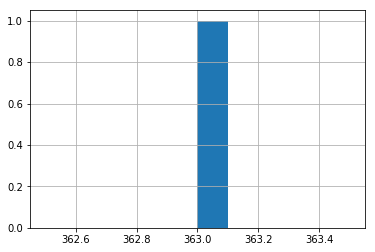

,"(Filt, Kingdom)","(Filt, Phylum)","(Filt, Class)","(Filt, Order)","(Filt, Family)","(Filt, Genus)","(Filt, Species)","(norm, Kingdom)","(norm, Phylum)","(norm, Class)","(norm, Order)","(norm, Family)","(norm, Genus)","(norm, Species)",repseq,len
OTU,,,,,,,,,,,,,,,,
OTU_33707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,not assigned,tgtggtagctatttctcaggctccctctcctgaatcaaaccctaat...,363


In [14]:
df= pd.concat([Ftaxa_18S_filt, taxa_18S], keys=['Filt', 'norm'], axis=1, join='inner')

df = pd.concat([df, seq_18S], axis=1, join='inner')
df=df.loc[df[('Filt', 'Kingdom')].isna()==True]
#df=df.loc[df[('Filt', 'Kingdom')].isna()==False]
print(list(df))
df['len'] = df['repseq'].str.len()
df['len'].hist()
test=df['repseq'].tolist()
print(test[:3])
plt.show()
df

# Look at Blast results: USEARCH contigs as a query vs Banzai contigs as DB

In [10]:
#USEARCH data as a query, Banzai data as the database
filename = '/Users/kpitz/Projects/Gulf_of_California/Geller_MB_blastn/Gellerquery_MBdb_18S_blastn_100119.xml'
#filename = '/Users/kpitz/Projects/Gulf_of_California/Geller_MB_blastn/MBquery_Gellerdb_COI_blastn_092419.xml'

result_handle =open(filename)
blast_records= NCBIXML.parse(result_handle)
#Dictionary to store hits
hit_dict ={}
for blast_record in blast_records:
    #query = blast_record.query.split('|')[1]
    query = blast_record.query
    #print(query)
    hit_ID=0
    for alignment in blast_record.alignments:
        hit_ID+=1       #hit ID counter
        if hit_ID >20:
            continue
        key = (query, hit_ID)
        hsp = alignment.hsps[0] #only look at top hsp
        #set limits on evalue and bitscore and % Identity
        per_iden = hsp.identities/float(hsp.align_length)
        per_iden = (per_iden *100)
        per_iden = round(per_iden, 2)
        evalue = hsp.expect
        bitscore = int(hsp.bits)
        #alignment length
        align_len = hsp.align_length
        
        value = (evalue, bitscore, per_iden, alignment.hit_def, align_len)
        hit_dict[key]=value

print ('Done parsing Blast xml File!')
#Save blast result stats to file
Blast_Results = pd.DataFrame(hit_dict)
Blast_Results=Blast_Results.T
Blast_Results.columns = ['eval','bitscore', '%ID', 'hit_def', 'align_len']

Gellerq = Blast_Results.copy()
Gellerq


Done parsing Blast xml File!


eval bitscore  \
Geller_18S|OTU_100|262|Radiozoa_ Polycystinea_ ... 1              0      658   
                                                   2              0      641   
                                                   3              0      641   
                                                   4              0      641   
                                                   5              0      641   
                                                   6              0      641   
                                                   7              0      636   
                                                   8   9.73802e-180      627   
                                                   9   3.50242e-179      625   
                                                   10  3.50242e-179      625   
                                                   11  1.25969e-178      623   
                                                   12  1.62952e-177      619   
                                                   13  5.86078e-177      617   
                                                   14  5.86078e-177      617   
                                                   15   7.5814e-176      614   
                                                   16   7.5814e-176      614   
                                                   17  1.64108e-172      603   
                                                   18  7.63522e-171      597   
                                                   19  3.55232e-169      592   
                                                   20  3.60294e-159      558   
Geller_18S|OTU_101|79| Arthropoda_ Malacostraca... 1              0      660   
                                                   2              0      643   
                                                   3   2.71566e-180      628   
                                                   4   5.87838e-177      617   
                                                   5   2.73494e-175      612   
                                                   6   2.73494e-175      612   
                                                   7   1.27245e-173      606   
                                                   8   5.92011e-172      601   
                                                   9   5.92011e-172      601   
                                                   10  5.92011e-172      601   
...                                                             ...      ...   
Geller_18S|OTU_99|350| Arthropoda_ Maxillopoda_... 11             0      658   
                                                   12             0      656   
                                                   13             0      656   
                                                   14             0      652   
                                                   15             0      652   
                                                   16             0      652   
                                                   17             0      652   
                                                   18             0      651   
                                                   19             0      645   
                                                   20             0      645   
Geller_18S|OTU_9|3404|NaN_NaN_NaN_NaN_NaN_NaN      1              0      667   
                                                   2              0      656   
                                                   3              0      656   
                                                   4              0      651   
                                                   5              0      651   
                                                   6              0      651   
                                                   7              0      649   
                                                   8              0      649   
                                                   9           

In [11]:
#get sequence length of USEARCH OTUs
df= Geller_18S.copy()
df.set_index('#OTU ID', inplace=True)
df=df[['Sequence']]
df['seqlen'] = df['Sequence'].str.len()
seqlen_Geller_18S = df.copy()
seqlen_Geller_18S.head()

,Sequence,seqlen
#OTU ID,,
OTU_1,ATGCATGTCTAAGTACAGGCCTAAGCAAGGCGAAACCGCGAATGGC...,387
OTU_10,ATGCATGTCTAAGTATAAACTTTTATACTGTGAAACTGCGAATGGC...,364
OTU_100,ATGCATATCTAAATGCTTTGTTTTTATAACATTAGATTGCGGACGG...,356
OTU_101,ATGCATGTCTAAGTACAGGCCTAAGCAAGGCGAAACTGCGAATAGC...,357
OTU_102,ATGCATGTCTAAGTACAAGCTCGTCTCGAGCGAAACTGCGGATGGC...,369


In [12]:
df= Gellerq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['hit_def'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['OTU'].str.split('|').str[1]
df.set_index('USEARCH_OTU', inplace=True)
df=df.join(seqlen_Geller_18S)
print('Total OTUs with Hits:',len(df.index))
tot_otus = len(df.index)
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']>=95]
df=df.loc[df['%ID']>=97]
print('Total OTUs with Good Hits:',len(df.index))
good_otus = len(df.index)
print('Percent Hits with >95% query coverage, >97% sequence identity:', good_otus/tot_otus *100)
#look at hits to any filtered out MB OTUs:
df= df.reset_index().set_index('MB_OTU')
cols = list(raw_18S_filt)
df= df.join(raw_18S_filt)
df['tot'] = df[cols].sum(axis=1)
df.drop(cols, inplace=True, axis=1)
df=df.sort_values('tot')
df=df.loc[df['tot']==0]
print('Total OTUs with Good Hits to Filtered-out contigs:',len(df.index))
df.head()

Total OTUs with Hits: 342
Total OTUs with Good Hits: 341
Percent Hits with >95% query coverage, >97% sequence identity: 99.70760233918129
Total OTUs with Good Hits to Filtered-out contigs: 30


,USEARCH_OTU,OTU,Hit_number,eval,bitscore,%ID,hit_def,align_len,Sequence,seqlen,Per_query,tot
MB_OTU,,,,,,,,,,,,
OTU_26559,OTU_203,Geller_18S|OTU_203|2|NaN_NaN_NaN_NaN_NaN_NaN,1,7.09348e-130,460,100,DUP_26559;size=5;,249,ATGCATGTCTAAGTACAGGCCTAAGCAAGGCGAAACCGCAAATGGC...,249.0,100,0.0
OTU_26505,OTU_209,Geller_18S|OTU_209|21| Arthropoda_ Malacostrac...,1,1.73787e-151,532,100,DUP_26505;size=11;,288,ATGCATGTCTAAGTACAGGCCTAAGCAAGGCGAAACCGCGAATGGC...,288.0,100,0.0
OTU_45626,OTU_159,Geller_18S|OTU_159|33| Arthropoda_ Malacostrac...,1,1.18782e-178,623,100,DUP_45626;size=4;,337,ATGCATGTCTAAGTACAGGCCTAAGCAAGGCGAAACTGTGAATAGC...,337.0,100,0.0
OTU_19033,OTU_207,Geller_18S|OTU_207|45| Arthropoda_ Malacostrac...,1,5.47358e-177,617,100,DUP_19033;size=11;,334,ATGCATGTCTAAGTACAGGCCTAAACAAGGCGAAACCGCGAATGGC...,334.0,100,0.0
OTU_15246,OTU_206,Geller_18S|OTU_206|36| Arthropoda_ Malacostrac...,1,1.49324e-172,603,100,DUP_15246;size=17;,326,ATGCATATCTAAGTACAGGCCTTTCTTACTTGGATAACTGTGGTAT...,326.0,100,0.0


In [20]:
#What OTU doesn't have a hit:
df= Gellerq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['hit_def'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['OTU'].str.split('|').str[1]
df.set_index('USEARCH_OTU', inplace=True)
df=df.join(seqlen_Geller_18S)
print('Total OTUs with Hits:',len(df.index))
tot_otus = len(df.index)
df['Per_query'] = df['align_len']/ df['seqlen'] *100

'''#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']>=95]
df=df.loc[df['%ID']>=97]
print('Total OTUs with Good Hits:',len(df.index))
good_otus = len(df.index)
print('Percent Hits with >95% query coverage, >97% sequence identity:', good_otus/tot_otus *100)
#look at hits to any filtered out MB OTUs:
df= df.reset_index().set_index('MB_OTU')
cols = list(raw_18S_filt)
df= df.join(raw_18S_filt)
df['tot'] = df[cols].sum(axis=1)
df.drop(cols, inplace=True, axis=1)
df=df.sort_values('tot')
df=df.loc[df['tot']==0]
print('Total OTUs with Good Hits to Filtered-out contigs:',len(df.index))'''
print(len(df.index))
#df=df.loc[df['Per_query'].isna()==True]
#print(len(df.index))
#df=df.loc[df['%ID']>=97]
#print(len(df.index))

df=df.loc[df['Per_query'].isna()==True]
print(df['OTU'].tolist())
df.head()



Total OTUs with Hits: 342
342
['Geller_18S|OTU_67|0|Protista_Dinoflagellata_Dinophyceae_Blastodiniales_Blastodinidae_Blastodinium_Blastodinium navicula']


,OTU,Hit_number,eval,bitscore,%ID,hit_def,align_len,MB_OTU,Sequence,seqlen,Per_query
USEARCH_OTU,,,,,,,,,,,
OTU_67,Geller_18S|OTU_67|0|Protista_Dinoflagellata_Di...,1,0,680,99.73,DUP_15201;size=25;,371,OTU_15201,NaN,NaN,NaN


In [22]:
df =Geller_18S_nr.copy()
df=df.loc[df['#OTU ID']=='OTU_67']
#>Geller_18S|OTU_67|0|Protista_Dinoflagellata_Dinophyceae_Blastodiniales_Blastodinidae_Blastodinium_Blastodinium navicula
#ATGCATGTCTCAGTATAAGCCTCTATATGGTGAAACTGCGAATGGCTCATTAATACAGTTATAGTTCACTTGATGGTTAGCCCTACATGGATAACTGTGGTAATTCTAGAGCTAATACATGAACTCATGCCCGACTTCATTGTGGAAGGGTTGTGTTTATTAGTTACAGAACCAACCCAGGCTTGTTCCTGGACATCTCTTGGTGATTCATGATAACCGAATGAATCGCGTAGCACCCGCTGGCGATGCATCATTCAAGTTTCTGACCTATCAGTTTCCGACGGTAGGGTATTGGCCTACCGTAGGCAACGACGGGTAACGGAGAATTAGGGTTCGATTCCGGAGAGGGAGCCTGAGAAATGGCTACCACA
#length 371
#lost when rarefied so that's why it's not in the sequence dataframe
print()
df

,#OTU ID,CP23_1,CP23,CP23_2,GOC2a,GOC2b,UC10,UC1,UC12,UC13,...,UC15,UC2,UC3_1,UC3,UC3_2,UC4,UC5,UC6,UC7,UC9
207,OTU_67,0,0,0,0,257,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
#look at which OTUs are hit by USEARCH OTUs
df= Gellerq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['hit_def'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['OTU'].str.split('|').str[1]
df.set_index('USEARCH_OTU', inplace=True)
df=df.join(seqlen_Geller_18S)
print('Total OTUs with Hits:',len(df.index))
tot_otus = len(df.index)
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']>=95]
df=df.loc[df['%ID']>=97]
print('Total OTUs with Good Hits:',len(df.index))
good_otus = len(df.index)
print('Percent Hits with >95% query coverage, >97% sequence identity:', tot_otus/good_otus *100)
#look at hits to any filtered out MB OTUs:
df= df.reset_index().set_index('MB_OTU')
df=pd.concat([df[['USEARCH_OTU','%ID', 'bitscore']], Ftaxa_18S_filt.fillna('un_ass')], axis=1, join='inner')
df['count'] = 1
#df = df.groupby(levels).sum()
df = df.groupby(levels[:3]).sum()
print(df.sum(axis=0))
df=df.sort_values('count', ascending=False)
df


Total OTUs with Hits: 342
Total OTUs with Good Hits: 341
Percent Hits with >95% query coverage, >97% sequence identity: 100.29325513196481
count    311
dtype: int64


count
Kingdom      Phylum          Class                     
Eukaryota    Arthropoda      Malacostraca            88
                             Hexanauplia             49
             unknown         Dinophyceae             29
             Mollusca        Gastropoda              26
             Annelida        Polychaeta              16
             p_              c_                      14
not assigned not assigned    not assigned            12
Eukaryota    Cnidaria        Hydrozoa                12
             Chordata        Thaliacea                9
             Chaetognatha    Sagittoidea              8
             Chordata        Appendicularia           8
                             Actinopteri              6
             unknown         unknown                  3
                             Polycystinea             3
             Arthropoda      Ostracoda                3
             Cnidaria        Anthozoa                 2
             Echinodermata   Asteroidea               2
             Ascomycota      Dothideomycetes          2
             unknown         Acantharea               2
             Hemichordata    Enteropneusta            2
             Mollusca        Bivalvia                 1
             Arthropoda      Branchiopoda             1
             Nemertea        Pilidiophora             1
             Ascomycota      Saccharomycetes          1
             Bacillariophyta Coscinodiscophyceae      1
             Echinodermata   Holothuroidea            1
             Haplosporidia   unknown                  1
             Echinodermata   Ophiuroidea              1
             Brachiopoda     unknown                  1
             Echinodermata   Echinoidea               1
             Ctenophora      Tentaculata              1
             Apicomplexa     Conoidasida              1
             Chlorophyta     c_                       1
             Bryozoa         Gymnolaemata             1
un_ass       un_ass          un_ass                   1

In [20]:
#look at which OTUs are hit by USEARCH OTUs
df= Gellerq.copy()
df.reset_index(inplace=True)
df = df.rename(columns={'level_0': 'OTU', 'level_1': 'Hit_number'})
df['MB_OTU']=df['hit_def'].str.split(';').str[0].str.replace('DUP','OTU')
#df=df.loc[df['MB_OTU'].isin(MB_18S_OTUs)==True]  #keep only size limited contigs
df = df.drop_duplicates(subset=['OTU'], keep='first') #keep just top hit (in blast file - by bitscore)
df['USEARCH_OTU']=df['OTU'].str.split('|').str[1]
df.set_index('USEARCH_OTU', inplace=True)
df=df.join(seqlen_Geller_18S)
print('Total OTUs with Hits:',len(df.index))
tot_otus = len(df.index)
df['Per_query'] = df['align_len']/ df['seqlen'] *100

#"good" hits; >95% query coverage, >97% sequence identity
df=df.loc[df['Per_query']>=95]
df=df.loc[df['%ID']>=97]
print('Total OTUs with Good Hits:',len(df.index))
good_otus = len(df.index)
print('Percent Hits with >95% query coverage, >97% sequence identity:', tot_otus/good_otus *100)
#look at hits to any filtered out MB OTUs:
df= df.reset_index().set_index('MB_OTU')
df=pd.concat([df[['USEARCH_OTU','%ID', 'bitscore']], Ftaxa_18S_filt.fillna('un_ass')], axis=1, join='inner')
df['count'] = 1
MB_match = df.index
print(len(MB_match))
MB_match = list(set(MB_match))
print(len(MB_match))
print(MB_match[:10])
#df.reset_index(inplace=True)
#df.drop_duplicates('index', inplace=True)
#df=df.sort_values('index')
df=df.loc[df['Species']=='Clausocalanus furcatus']
df


Total OTUs with Hits: 342
Total OTUs with Good Hits: 341
Percent Hits with >95% query coverage, >97% sequence identity: 100.29325513196481
311
311
['OTU_4415', 'OTU_5020', 'OTU_4041', 'OTU_5149', 'OTU_45661', 'OTU_16351', 'OTU_11201', 'OTU_26523', 'OTU_16812', 'OTU_3421']


,USEARCH_OTU,%ID,bitscore,Kingdom,Phylum,Class,Order,Family,Genus,Species,count


In [281]:
#USEARCH contigs clustered at 95% identity for COI so much less sequence diversity for the same species

In [21]:
df = Ftaxa_18S_filt.copy()
df=df.loc[df['Species']=='Clausocalanus furcatus']
df


,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU,,,,,,,
OTU_100072,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_100092,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_100791,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_100918,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_101162,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_101246,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_101496,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_101668,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
OTU_103610,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus
